# Function Approximation


Implement another form of FunctionApprox beyond what we’ve covered in class (we covered linear function approximation, deep neural networks, and tabular). If you have taken a course in
statistical learning, you can try implementing Generalized Additive Model (GAM). Otherwise, try
implementing Univariate B-Spline. Be sure to test your implementation on an appropriate data
set - you can generate a data set from a model (from either the same model you are implementing
or a similar/related model).

In [69]:
#Import:
from __future__ import annotations
import sys
sys.path.append("../../RL-book")
from dataclasses import dataclass, replace, field
from scipy.interpolate import splrep, BSpline
from typing import Callable, Iterable, Sequence, Tuple, TypeVar, Optional
from rl.function_approx import FunctionApprox
import matplotlib.pyplot as plt
import numpy as np
import rl.iterate as iterate

X = TypeVar('X')
SMALL_NUM = 1e-6

In [70]:
@dataclass(frozen=True)
class BSplineApprox(FunctionApprox[X]):
    feature_function: Callable[[X], float]
    degree: int
    knots: np.ndarray = field(default_factory=lambda: np.array([]))
    coeffs: np.ndarray = field(default_factory=lambda: np.array([]))

    def get_feature_values(self, x_values_seq: Iterable[X]) -> Sequence[float]:
        return [self.feature_function(x) for x in x_values_seq]

    def representational_gradient(self, x_value: X) -> BSplineApprox[X]:
        #pass
        feature_val: float = self.feature_function(x_value)
        eps: float = 1e-6
        one_hots: np.array = np.eye(len(self.coeffs))
        return replace(
            self,
            coeffs=np.array([(
                BSpline(
                    self.knots,
                    c + one_hots[i] * eps,
                    self.degree
                )(feature_val) -
                BSpline(
                    self.knots,
                    c - one_hots[i] * eps,
                    self.degree
                )(feature_val)
            ) / (2 * eps) for i, c in enumerate(self.coeffs)]))

    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        spline_func: Callable[[Sequence[float]], np.ndarray] = \
            BSpline(self.knots, self.coeffs, self.degree)
        return spline_func(self.get_feature_values(x_values_seq))

    def update(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]]) -> BSplineApprox[X]:
        x_vals, y_vals = zip(*xy_vals_seq)
        feature_vals: Sequence[float] = self.get_feature_values(x_vals)
        sorted_pairs: Sequence[Tuple[float, float]] = \
            sorted(zip(feature_vals, y_vals), key=itemgetter(0))
        new_knots, new_coeffs, _ = splrep(
            [f for f, _ in sorted_pairs],
            [y for _, y in sorted_pairs],
            k=self.degree)
        return replace(self, knots=new_knots, coeffs=new_coeffs)
    
    #Added solve method to properly update the approximation
    def solve(self,xy_vals_seq: Iterable[Tuple[X, float]],error_tolerance: Optional[float] = None) -> BSplineApprox[X]:
        return self.update(xy_vals_seq)

    def within(self, other: FunctionApprox[X], tolerance: float) -> bool:
        if isinstance(other, BSplineApprox):
            return \
                np.all(np.abs(self.knots - other.knots) <= tolerance).item() \
                and \
                np.all(np.abs(self.coeffs - other.coeffs) <= tolerance).item()

        return False
        

# Testing BSpline:

## Generating Test data:

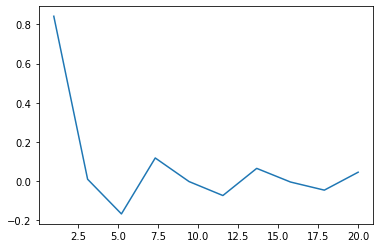

In [71]:
X = np.linspace(1,20,10)
Y = np.sin(X)/X

plt.plot(X,Y)

#Convert to proper input:
xy_seq = []
for i,x in enumerate(X):
    xy_seq.append((x,Y[i]))

## Fit data with function approximation:

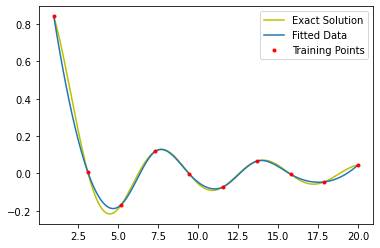

In [76]:
def feature_func(x):
    return lambda x: x

feature_function = feature_func(x)
degree = 3

Bspline_test=BSplineApprox(feature_function,degree)
Bspline_approx = Bspline_test.solve(xy_seq)

X_test = np.linspace(1,20,100)

X_exact = np.linspace(1,20,1000)
Y_exact = np.sin(X_exact)/X_exact

plt.plot(X_exact,Y_exact,'y')
plt.plot(X_test,Bspline_approx.evaluate(X_test))
plt.plot(X,Y,'r.')
plt.legend(["Exact Solution","Fitted Data","Training Points"])

That's a pretty solid fit for only 10 points, nice.